In [90]:
import importlib
importlib.reload(pw)

<module 'features_pairwise' from '/home/jacob/JUPYTER PROJECTS/ML/project/features_pairwise.py'>

In [66]:
import features_nodewise as nw
import features_pairwise as pw
import preprocessing as prep

import random
import numpy as np
import igraph
from sklearn import preprocessing
import nltk
import csv
from functools import reduce
from sklearn import metrics
from nltk.tokenize import RegexpTokenizer

nltk.download('punkt') # for tokenization
nltk.download('stopwords')
stpwds = set(nltk.corpus.stopwords.words("english"))
stemmer = nltk.stem.PorterStemmer()

with open("./data/train_train_set.csv", "r") as f:
    reader = csv.reader(f)
    training_set  = list(reader)

with open("./data/train_test_set.csv", "r") as f:
    reader = csv.reader(f)
    testing_set  = list(reader)

training_set = [element[0].split(" ") for element in training_set]
to_keep_train = random.sample( range(len(training_set)),k=int(round(len(training_set)*0.05)) )
training_set_reduced = [training_set[i] for i in to_keep_train]

testing_set = [element[0].split(" ") for element in testing_set]
to_keep_test = random.sample( range(len(testing_set)),k=int(round(len(testing_set)*.37)) )
testing_set_reduced = [testing_set[i] for i in to_keep_test]

with open("./data/node_information.csv", "r") as f:
    reader = csv.reader(f)
    node_info  = list(reader)

IDs = [element[0] for element in node_info]
node_dict = prep.to_dict( [element[0] for element in node_info],range(len(node_info)) )
index_dict = prep.to_dict(range(len(IDs)),IDs)

# compute TFIDF vector of each paper
corpus = [element[5] for element in node_info]

t = prep.tfidf(corpus)
l = nw.LSA(t,n_components=250)

true_edges = [(element[0],element[1]) for element in training_set if element[2]=="1"]
no_citation = [(element[0],element[1]) for element in training_set if element[2]=="0"]
edges= [(element[0],element[1]) for element in training_set]

[nltk_data] Downloading package punkt to /home/jacob/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jacob/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
n_samples: 27770, n_features: 10000
Performing dimensionality reduction using LSA
Explained variance of the SVD step: 32%


In [97]:
kdtree = nw.KDTree(l)
graph = prep.article_graph(IDs,edges)

In [16]:
from sklearn.linear_model import LogisticRegression as lr

    
def weighted_overlap(f,true_pairs,false_pairs,outputs=None):
    if outputs==None:
        true_f_values = [f(p[0],p[1]) for p in true_pairs]
        true_mean = np.mean(true_f_values)
        false_f_values = [f(p[0],p[1]) for p in false_pairs]
        false_mean = np.mean(false_f_values)
        t_true = len(true_f_values)
        t_false = len(false_f_values)

        if true_mean>=false_mean:
            m = max(false_f_values)
            #could be improved by iteratively adding instead of redoing len(list) for every val
            f_overlaps = [len([f for f in false_f_values if f>=val]) for val in true_f_values if val<=m]
            f_overlaps = sum(f_overlaps) / ( t_true*t_false )
        else:
            m = min(false_f_values)
            #could be improved by iteratively adding instead of redoing len(list) for every val
            f_overlaps = [len([f for f in false_f_values if f<=val]) for val in true_f_values if val>=m]
            f_overlaps = sum(f_overlaps) / ( t_true*t_false )

        return f_overlaps
    
    else:
        all_true_f_values = np.array([f(p[0],p[1]) for p in true_pairs])
        all_false_f_values = np.array([f(p[0],p[1]) for p in false_pairs])
        all_f_overlaps=[]
        for o in outputs:
            true_f_values = all_true_f_values[:,o]
            false_f_values = all_false_f_values[:,o]
            true_mean = np.mean(true_f_values)
            false_mean = np.mean(false_f_values)
            t_true = len(true_f_values)
            t_false = len(false_f_values)

            if true_mean>=false_mean:
                m = max(false_f_values)
                #could be improved by iteratively adding instead of redoing len(list) for every val
                f_overlaps = [len([f for f in false_f_values if f>=val]) for val in true_f_values if val<=m]
                f_overlaps = sum(f_overlaps) / ( t_true*t_false )
            else:
                m = min(false_f_values)
                #could be improved by iteratively adding instead of redoing len(list) for every val
                f_overlaps = [len([f for f in false_f_values if f<=val]) for val in true_f_values if val>=m]
                f_overlaps = sum(f_overlaps) / ( t_true*t_false )

            all_f_overlaps.append(f_overlaps)
        return all_f_overlaps

def error_overlap(f,g,sample_set):
    test_set = np.array(sample_set[:int(len(sample_set)/2)])
    train_set = np.array(sample_set[int(len(sample_set)/2):])
    modelf = lr(penalty='l1',solver='liblinear').fit(np.array([f(p[0],p[1]) for p in train_set]).reshape(-1, 1)
                                                     ,train_set[:,2])
    modelg = lr(penalty='l1',solver='liblinear').fit(np.array([g(p[0],p[1]) for p in train_set]).reshape(-1, 1)
                                                     ,train_set[:,2])
    predsf = modelf.predict(np.array([f(p[0],p[1]) for p in test_set]).reshape(-1, 1))
    predsg = modelg.predict(np.array([g(p[0],p[1]) for p in test_set]).reshape(-1, 1))
    
    first = False
    counts=[0,0,0]
    for i in range(len(predsf)):
        if predsf[i]!=test_set[:,2][i]: 
            first = True
            counts[0]+=1
        if predsg[i]!=test_set[:,2][i]: 
            counts[1]+=1
            if first==True: counts[2]+=1
        first = False
        
    return counts[2]/min([counts[0],counts[1]])

In [31]:
import random
from sklearn.metrics.pairwise import cosine_distances as COS
import math

def Citation_Check(source_ID,target_ID,kdtree,features,graph,node_dict,index_dict,k=500):
    """
    @features param4: the array of features i.e. points which were used to build the kdtree
    @return: numpy array [% KNN of source which cite target, % KNN of target which are cited by source]
    """
    close_source = pw.Get_K_NN(source_ID,kdtree,features,node_dict,index_dict,k_val=k)[0]
    close_target = pw.Get_K_NN(target_ID,kdtree,features,node_dict,index_dict,k_val=k)[0]
    cite_percent = len([n for n in close_source if graph.are_connected(n,target_ID)])/len(close_source)
    w_s_p = sum([math.log2(500-i+1) for i,x in enumerate(close_source) if graph.are_connected(x,target_ID)])/5500
    w_t_p = sum([math.log2(500-i+1) for i,x in enumerate(close_target) if graph.are_connected(source_ID,x)])/5500
    cited_percent = len([n for n in close_target if graph.are_connected(source_ID,n)])/len(close_target)

    return np.array([cite_percent,cited_percent,w_s_p,w_t_p])
    
# seems like Max_Sim does better on graph with noise edges left in???
# 0.05    lambda s,t: pw.Max_Sim(s,t,l,graph,node_dict)[3] (similar for 3,4,7)
# 0.05    lambda s,t: pw.Citation_Check(s,t,kdtree,l,graph,node_dict,index_dict,k=500)[3] (2,3 better than 0,1) 
# 0.15    lambda s,t: pw.peer_popularity(graph,s,t)
# 1.00    lambda s,t: pw.edge_check(s,t,graph)
# 0.11    lambda s,t: pw.LSA_distance(s,t,node_dict,l)
# 0.15    lambda s,t: pw.node_degree(s,t,graph)[2]
# 0.05    lambda s,t: pw.succ_pred(s,t,graph)[3] (all similar)
# 0.37    lambda s,t: pw.baseline(s,t,node_dict,node_info)[3] i.e. time diff
# 0.17    graph distance (probably better after removing 50% of noise edges)

score_MS = []
for n in range(1):
     score_MS.append(weighted_overlap(lambda s,t: pw.Max_Sim(s,t,l,graph,node_dict),random.sample(true_edges,1000),random.sample(no_citation,1000),range(9)))

score_SP = []
for n in range(1):
    score_SP.append(weighted_overlap(lambda s,t: pw.succ_pred(s,t,graph),random.sample(true_edges,5000),random.sample(no_citation,5000),range(4)))

score_CC = []
for n in range(1):
     score_CC.append(weighted_overlap(lambda s,t: Citation_Check(s,t,kdtree,l,graph,node_dict,index_dict,k=500),random.sample(true_edges,2000),random.sample(no_citation,2000),range(4)))
score_CC

In [91]:
import random

#USE: CC:3, SP:3, MS:3


#errors_MS3_SP: [0.38, 0.38, 0.43, 0.31]

errors_MS3_SP=[]
for n in range(4):
    errors_MS3_SP.append(error_overlap(lambda s,t: pw.Max_Sim(s,t,l,graph,node_dict)[3],lambda s,t: pw.succ_pred(
        s,t,graph)[n],random.sample(training_set,2000)))
print(1)
#errors_MS7_SP: [0.42,0.34,0.37,0.30]

errors_MS7_SP=[]
for n in range(4):
    errors_MS7_SP.append(error_overlap(lambda s,t: pw.Max_Sim(s,t,l,graph,node_dict)[7],lambda s,t: pw.succ_pred(
        s,t,graph)[n],random.sample(training_set,2000)))
print(2)

# errors_CC_MS: [.61,.46,.28,.25]
errors_CC_MS=[]
for n in [2,3]:
    for m in [3,7]:
        errors_CC_MS.append(error_overlap(lambda s,t: pw.Max_Sim(s,t,l,graph,node_dict)[m],
            lambda s,t: pw.Citation_Check(s,t,kdtree,l,graph,node_dict,index_dict,k=500)[n],
                                          random.sample(training_set,2000)))
print(3)

#errors_CC_SP: [0.5, 0.43,.51,.43,.65,.5,.31]
errors_CC_SP=[]
for n in [2,3]:
    for m in range(4):
        errors_CC_SP.append(error_overlap(lambda s,t: pw.succ_pred(s,t,graph)[m],
            lambda s,t: pw.Citation_Check(s,t,kdtree,l,graph,node_dict,index_dict,k=500)[n],
                                          random.sample(training_set,2000)))
    

3


In [44]:
from sklearn.feature_selection import f_regression, mutual_info_regression

X=[]
Y=[]
for i in range(4):
    X.append([])
    Y.append([])
    random.seed(0)
    for p in random.sample(training_set,2000):
        if i==0:
            X[i].append(pw.Max_Sim(p[0],p[1],l,graph,node_dict)[3])
        Y[i].append(pw.succ_pred(p[0],p[1],graph)[i])
mi = mutual_info_regression(np.array(Y), X[0])

ValueError: Expected 2D array, got 1D array instead:
array=[0.87064956 0.54104473 0.82889516 ... 0.82901791 0.43395938 0.5270261 ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [98]:
features = []
true_labels = []

to_del = []
for i,triple in enumerate(training_set):
    source = triple[0]
    target = triple[1]
    index_source = node_dict[source]
    index_target = node_dict[target]
    source_info = node_info[index_source]
    target_info = node_info[index_target]
    temp_diff = int(source_info[1]) - int(target_info[1])
    if temp_diff<-1:
        to_del.append((source,target))

graph.delete_edges(to_del)

random.seed(0)
t_r = random.sample(training_set,5000)
# nodes = set([t_r[i][0] for i in range(len(t_r))])
# nodes = nodes | set([t_r[i][1] for i in range(len(t_r))])
# l1 = [l[node_dict[i]] for i in nodes]
# kdtree = nw.KDTree(l1)


# for i,triple in enumerate(training_set):

for i,triple in enumerate(t_r):
    f=[]
    source = triple[0]
    target = triple[1]
#     index_source = node_dict[source]
#     index_target = node_dict[target]
#     source_info = node_info[index_source]
#     target_info = node_info[index_target]

#     # convert to lowercase and tokenize
#     source_title = source_info[2].lower().split(" ")
#     # remove stopwords
#     source_title = [token for token in source_title if token not in stpwds]
#     source_title = [stemmer.stem(token) for token in source_title]

#     target_title = target_info[2].lower().split(" ")
#     target_title = [token for token in target_title if token not in stpwds]
#     target_title = [stemmer.stem(token) for token in target_title]

#     source_auth = source_info[3].split(",")
#     target_auth = target_info[3].split(",") 

#     overlap_title = len(set(source_title).intersection(set(target_title)))
#     temp_diff = int(source_info[1]) - int(target_info[1])
#     comm_auth = len(set(source_auth).intersection(set(target_auth)))
    
    f.append(pw.Max_Sim(source,target,l,graph,node_dict)[3])
    f.append(pw.Citation_Check(source,target,kdtree,l,graph,node_dict,index_dict,k=500)[3])
#     f.append(pw.peer_popularity(graph,source,target))
#     f.append(pw.edge_check(source,target,graph))
    f.append(pw.LSA_distance(source,target,node_dict,l,metric='COS'))
#     f.append(pw.node_degree(source,target,graph)[2])
#     f.append(len(set(source_title).intersection(set(target_title))))
#     f.append(int(source_info[1]) - int(target_info[1]))
#     f.append(len(set(source_auth).intersection(set(target_auth))))
    f.append(pw.succ_pred(source,target,graph)[3])

    features.append(f)
    true_labels.append(triple[2])
    
    if i%1000==0:
        print(i)

features=np.array(features)
true_labels=np.array(true_labels)

0
1000
2000
3000
4000


In [271]:
#build model from t_r
from sklearn.linear_model import LogisticRegression as lr
model = lr(penalty='l1',solver='liblinear').fit(features,true_labels)

In [272]:
#for applying model
features1 = []
true_labels1=[]

random.seed(1)
t_r1 = random.sample(training_set,5000)

for i,triple in enumerate(t_r1):
    f=[]
    source = triple[0]
    target = triple[1]

    f.append(pw.Max_Sim(source,target,l,graph,node_dict)[3])

    f.append(pw.LSA_distance(source,target,node_dict,l,metric='COS'))

    f.append(pw.succ_pred(source,target,graph)[3])

    features1.append(f)
    true_labels1.append(triple[2])
    
    if i%1000==0:
        print(i)

features1=np.array(features1)

0
1000
2000
3000
4000


In [281]:
#then apply to f_r1/features1
pred_probs = list(model.predict_proba(features1))

In [274]:
#delete based on preds from t_r1
to_del=[]

for i,triple in enumerate(t_r1):
    source = triple[0]
    target = triple[1]
    index_source = node_dict[source]
    index_target = node_dict[target]
    source_info = node_info[index_source]
    target_info = node_info[index_target]
    temp_diff = int(source_info[1]) - int(target_info[1])
    
    if pred_probs[i][1]<=0.15 and temp_diff>=-1:
        to_del.append((source,target))

graph.delete_edges(to_del)

In [275]:
#recompute features on t_r1
features2 = []
true_labels2 = []

for i,triple in enumerate(t_r1):
    f=[]
    source = triple[0]
    target = triple[1]

    f.append(pw.Max_Sim(source,target,l,graph,node_dict)[3])

    f.append(pw.LSA_distance(source,target,node_dict,l,metric='COS'))

    f.append(pw.succ_pred(source,target,graph)[3])

    features2.append(f)
    true_labels2.append(triple[2])
    
    if i%1000==0:
        print(i)

features2=np.array(features2)
true_labels2=np.array(true_labels2)

0
1000
2000
3000
4000


In [276]:
#build model1 based on removed-edges t_r1+features2
from sklearn.linear_model import LogisticRegression as lr
model1 = lr(penalty='l1',solver='liblinear').fit(features2,true_labels2)

In [102]:
import pickle
# with open('./features_train/reduced', 'wb') as f:
#     pickle.dump([training_set_reduced,graph,l,kdtree,node_dict,index_dict,true_labels],f)
# with open('./features_train/reduced_features', 'wb') as f:
#     pickle.dump(feature,f)
with open('./features_train/reduced', 'rb') as f:
    training_set_reduced,graph,l,kdtree,node_dict,index_dict,true_labels=pickle.load(f)
with open('./features_train/reduced_features', 'rb') as f:
    features=pickle.load(f)
#order: max_sim,citation_check,peer_popularity,edge_check,lsa_distance,node_degree,title,time,author


In [ ]:
from sklearn.preprocessing import normalize
#currently: 0:CC%,1:CC%,2:Max_Sim..6:Max_Sim,7:avg(max_sim),8:overlap_title,9:temp_diff,10:comm_auth
#temp-diff should be normalized or preprocessed
#as should common_auth?

normalized_features = normalize(features,axis=0)
max([features[i][8] for i in range(1000)])

In [100]:
random.seed(0)
te_r = random.sample(testing_set,1000)

# nodes = set([te_r[i][0] for i in range(len(te_r))])
# nodes = nodes | set([te_r[i][1] for i in range(len(te_r))])
# l1 = [l[node_dict[i]] for i in nodes]
# test_kdtree = nw.KDTree(l1)

test_all_edges = [(element[0],element[1]) for element in testing_set]
test_graph = prep.article_graph(IDs,test_all_edges)

test_features = []
test_true_labels = []

to_del = []
for i,triple in enumerate(testing_set):
    source = triple[0]
    target = triple[1]
    index_source = node_dict[source]
    index_target = node_dict[target]
    source_info = node_info[index_source]
    target_info = node_info[index_target]
    temp_diff = int(source_info[1]) - int(target_info[1])
    if temp_diff<-1:
        to_del.append((source,target))

test_graph.delete_edges(to_del)

temp=[]
for i,triple in enumerate(te_r):
    
    source = triple[0]
    target = triple[1]
#     index_source = node_dict[source]
#     index_target = node_dict[target]
    
#     source_info = node_info[index_source]
#     target_info = node_info[index_target]

#     # convert to lowercase and tokenize
#     source_title = source_info[2].lower().split(" ")
#     # remove stopwords
#     source_title = [token for token in source_title if token not in stpwds]
#     source_title = [stemmer.stem(token) for token in source_title]

#     target_title = target_info[2].lower().split(" ")
#     target_title = [token for token in target_title if token not in stpwds]
#     target_title = [stemmer.stem(token) for token in target_title]

#     source_auth = source_info[3].split(",")
#     target_auth = target_info[3].split(",") 

#     overlap_title = len(set(source_title).intersection(set(target_title)))
#     temp_diff = int(source_info[1]) - int(target_info[1])
#     comm_auth = len(set(source_auth).intersection(set(target_auth)))
    
    f = []
    f.append(pw.Max_Sim(source,target,l,test_graph,node_dict)[3])
    f.append(pw.Citation_Check(source,target,kdtree,l,test_graph,node_dict,index_dict,k=500)[3])
#     f.append(pw.peer_popularity(test_graph,source,target))
#     f.append(pw.edge_check(source,target,test_graph))
    f.append(pw.LSA_distance(source,target,node_dict,l,metric='COS'))
#     f.append(pw.node_degree(source,target,test_graph)[2])
#     f.append(overlap_title)
#     f.append(temp_diff)
#     f.append(comm_auth)
    f.append(pw.succ_pred(source,target,graph)[3])
    
    
    test_features.append(f)
    test_true_labels.append(triple[2])
    if i%1000==0:
        print(i)
        
test_features=np.array(test_features)
test_true_labels=np.array(test_true_labels)

0


In [278]:
#apply model to predict which edges to drop
pred_probs = list(model.predict_proba(test_features))

In [37]:
#generate features to input to model1

test_features1 = []
test_true_labels1 = []

#delete based on preds from t_r1
to_del=[]

for i,triple in enumerate(te_r):
    source = triple[0]
    target = triple[1]
    index_source = node_dict[source]
    index_target = node_dict[target]
    source_info = node_info[index_source]
    target_info = node_info[index_target]
    temp_diff = int(source_info[1]) - int(target_info[1])
    
    if pred_probs[i][1]<=0.15 and temp_diff>=-1:
        to_del.append((source,target))

test_graph.delete_edges(to_del)

temp=[]
for i,triple in enumerate(te_r):
    
    source = triple[0]
    target = triple[1]
    
    f = []
    f.append(pw.Max_Sim(source,target,l,test_graph,node_dict)[3])
    f.append(pw.LSA_distance(source,target,node_dict,l,metric='COS'))
    f.append(pw.succ_pred(source,target,graph)[3])
    
    test_features1.append(f)
    test_true_labels1.append(triple[2])
    if i%1000==0:
        print(i)
        
test_features1=np.array(test_features1)
test_true_labels1=np.array(test_true_labels1)

NameError: name 'te_r' is not defined

In [280]:
preds = list(model1.predict(test_features1))
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds)))
print('acc:',acc,'f1:',f1)

acc: 0.92 f1: 0.9236641221374047


In [114]:
import pickle
# with open('./features_test/reduced', 'wb') as f:
#     pickle.dump([testing_set_reduced,test_graph,l,test_kdtree,node_dict,index_dict,test_true_labels],f)
# with open('./features_test/reduced_features', 'wb') as f:
#     pickle.dump(test_features,f)
# order: max_sim,citation_check,peer_popularity,edge_check,lsa_distance,node_degree,title,time,author
with open('./features_test/reduced', 'rb') as f:
    testing_set_reduced,test_graph,l,test_kdtree,node_dict,index_dict,test_true_labels = pickle.load(f)
with open('./features_test/reduced_features', 'rb') as f:
    test_features = pickle.load(f)

In [ ]:
import random
# for citation_check:
# mean of true but removed edges (with 50% edges removed) is 0.031
# mean of no edge pairs (with 50% edges removed) is 0.0003

[pw.Citation_Check(e[0],e[1],kdtree,l,graph,node_dict,index_dict,k=20) for e in random.sample(edges[150000:],20)]
np.mean([pw.Citation_Check(e[0],e[1],kdtree,l,graph,node_dict,index_dict,k=20) for e in random.sample(no_citation,1500)])

#for Max_Sim:
#mean of true... is 1.13
#mean of no edge... is 0.58
a = np.mean([np.mean(pw.Max_Sim(e[0],e[1],l,graph,node_dict)) for e in random.sample(edges[150000:],1500)])
b = np.mean([np.mean(pw.Max_Sim(e[0],e[1],l,graph,node_dict)) for e in random.sample(no_citation,1500)])

In [5]:
#Import libraries:
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
# from sklearn import cross_validation, 
from sklearn import metrics   #Additional scklearn functions
# from sklearn.grid_search import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt


def modelfit(alg, features, true_labels,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
#     if useTrainCV:
#         xgb_param = alg.get_xgb_params()
#         xgtrain = xgb.DMatrix(features, label=true_labels)
#         cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
#             metrics='auc', early_stopping_rounds=early_stopping_rounds)
#         alg.set_params(n_estimators=cvresult)
    
    #Fit the algorithm on the data
    alg.fit(features, true_labels,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(features)
    dtrain_predprob = alg.predict_proba(features)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(true_labels, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(true_labels, dtrain_predprob))
                    
#     feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
#     feat_imp.plot(kind='bar', title='Feature Importances')
#     plt.ylabel('Feature Importance Score')

In [101]:
xgb1 = XGBClassifier(
 learning_rate =0.01,#0.01
 max_depth=8, 
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 scale_pos_weight=0.67,
 objective= 'binary:logistic',
)

modelfit(xgb1, features, true_labels,useTrainCV=True)

preds = xgb1.predict(test_features)
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds)))
print('acc:',acc,'f1:',f1)


Model Report
Accuracy : 0.9694
AUC Score (Train): 0.995091
acc: 0.873 f1: 0.865037194473964


In [108]:
np.argsort(list(map(lambda x: abs(x),model.coef_)))

array([[ 6,  7, 11,  3, 13, 14, 16,  4,  0, 12,  2,  1,  5, 15, 17,  9,
         8, 10]])

In [112]:
model.coef_

array([[ -2.04329983,  37.74762202, -11.5304449 ,  31.1264739 ]])

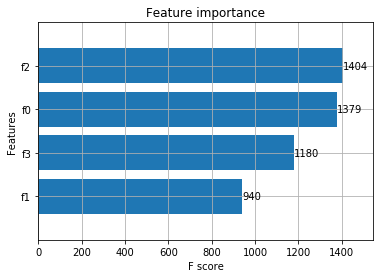

In [113]:
fig, ax = plt.subplots()
xgb.plot_importance(xgb1, max_num_features=50, height=0.8, ax=ax)
plt.show()
##order: 0-5max_sim,6-7citation_check,8peer_popularity,9edge_check,
#10lsa_distance,11-14node_degree,15title,16time,17author


In [92]:
short_features=features[:,[0,  2,  1, 15, 17,  9,8, 10]]
short_test_features = test_features[:,[0,  2,  1, 15, 17,  9,8, 10]]

In [110]:
from sklearn import svm
import statistics as s
from sklearn.svm import SVC

classifier = svm.LinearSVC()
# classifier = SVC(gamma='auto')
# try with gridsearch on C and gamma 
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

# normalize
features1 = np.zeros(features.shape)
features1[:,0]=(features[:,0]-np.mean(features[:,0])) /s.stdev(features[:,0])
features1[:,1]=(features[:,1]-np.mean(features[:,1])) /s.stdev(features[:,1])
features1[:,2]=(features[:,2]-np.mean(features[:,2])) /s.stdev(features[:,2])
features1[:,3]=(features[:,3]-np.mean(features[:,3])) /s.stdev(features[:,3])

test_features1 = np.zeros(test_features.shape)
test_features1[:,0]=(test_features[:,0]-np.mean(test_features[:,0])) /s.stdev(test_features[:,0])
test_features1[:,1]=(test_features[:,1]-np.mean(test_features[:,1])) /s.stdev(test_features[:,1])
test_features1[:,2]=(test_features[:,2]-np.mean(test_features[:,2])) /s.stdev(test_features[:,2])
test_features1[:,3]=(test_features[:,3]-np.mean(test_features[:,3])) /s.stdev(test_features[:,3])

                                                               

classifier.fit(features1, true_labels)
preds= list(classifier.predict(test_features1))
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds)))
print('acc:',acc,'f1:',f1)

acc: 0.921 f1: 0.9277218664226898


In [145]:
from sklearn.linear_model import LogisticRegression as lr
model = lr(penalty='l1',solver='liblinear').fit(features,true_labels)
cf = model.get_params()
preds = list(model.predict(test_features))
preds_probs = list(model.predict_proba(test_features))
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds)))
print('acc:',acc,'f1:',f1)

acc: 0.922 f1: 0.9233791748526522


In [183]:
np.where(preds!=test_true_labels)[0][7]

184

In [187]:
node_info[node_dict[te_r[184][0]]]

['207157',
 '2002',
 'gauge invariant action for superstring in ramond-ramond plane-wave',
 'Machiko Hatsuda, Kiyoshi Kamimura, Makoto Sakaguchi',
 'Nucl.Phys.',
 'background we present a gauge invariant action for a superstring in the plane wave background with ramond-ramond rr five-form flux the wess-zumino term is given explicitly in a bilinear form of the left invariant currents by introducing a fermionic center to define the nondegenerate group metric the reparametrization invariance generators whose combinations are conformal generators and fermionic constraints half of which generate kappa-symmetry are obtained equations of motion are obtained in conformal invariant and background covariant manners']

In [186]:
node_info[node_dict[te_r[184][1]]]

['9909164',
 '2000',
 'more d-branes in the nappi-witten background',
 "JM Figueroa-O'Farrill, S Stanciu",
 'JHEP',
 'we re-examine the problem of determining the possible d-branes in the nappi-witten background in addition to the known branes we find that there are also d-instantons flat euclidean d-strings and curved d-membranes admitting parallel spinors all of which can be interpreted as twisted conjugacy classes in the nappi-witten group']

In [200]:
len(np.where(np.array(preds)=='1')[0])

491

In [108]:
from sklearn.neighbors import KNeighborsClassifier

nNhbr = KNeighborsClassifier()
nNhbr.fit(features,true_labels) # do Ytrain.ravel() for length one Y values
preds = nNhbr.predict(test_features)
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds)))
print('acc:',acc,'f1:',f1)

acc: 0.898 f1: 0.8950617283950617


In [109]:
from sklearn.tree import DecisionTreeClassifier

dTree = DecisionTreeClassifier()
dTree.fit(features,true_labels) # do Ytrain.ravel() for length one Y values
preds = dTree.predict(test_features)
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds)))
print('acc:',acc,'f1:',f1)

acc: 0.859 f1: 0.8507936507936508


In [310]:
import tensorflow as tf
import numpy as np
import time
import math


class Class_Net():

    def __init__(self, learning_rate=0.001, batch_size=60):
        ''' initialize the classifier with default (best) parameters '''
        tf.reset_default_graph()
        self.alpha = learning_rate
        self.beta = batch_size
        self.warm = False

    def fit(self,X,Y,warm_start=True,n_epochs=50):
        ''' train the network, and if warm_start, then do not reinit. the network
            (if it has already been initialized)
        '''
        self.epochs=n_epochs

        self.n_batch = int(len(X)/self.beta)
        
        if warm_start==False or self.warm==False:
            self.x = tf.placeholder(tf.float32,shape=[None,len(X[0])])
            self.y = tf.placeholder(tf.float32,shape=[None,1])
            
            self.wZero = tf.get_variable('wZero',shape=[len(X[0]),50],initializer=tf.glorot_uniform_initializer())
            self.bZero = tf.Variable(tf.zeros([50]))

            self.wOne = tf.get_variable('wOne',shape=[50,1],initializer=tf.glorot_uniform_initializer())
            self.bOne = tf.Variable(tf.zeros([1]))
            self.keep_prob = 1
            self.drop_out = tf.nn.dropout(self.x, self.keep_prob)
            self.model = tf.nn.sigmoid(tf.matmul(tf.nn.relu(tf.matmul(self.drop_out, self.wZero) 
                                              + self.bZero),self.wOne)+self.bOne)
            self.cost = tf.losses.log_loss(self.y,self.model)
            
#             self.optimizer = tf.train.GradientDescentOptimizer(self.alpha).minimize(self.cost)
            self.optimizer = tf.train.AdamOptimizer(learning_rate=self.alpha).minimize(self.cost)

            #without dropout
#             self.model = tf.matmul(tf.nn.relu(tf.matmul(self.x, self.wZero) + self.bZero),self.wOne)+self.bOne

    
            self.saver = tf.train.Saver()
            self.init = tf.global_variables_initializer()
            
        with tf.Session() as sess:
            if warm_start==False or self.warm==False:
                sess.run(self.init)
            else:
                self.saver.restore(sess, './tempVariables.ckpt')
            for epoch in range(self.epochs):
                self.avg_cost = 0
                for i in range(self.n_batch):
                    _, self.c = sess.run([self.optimizer,self.cost], feed_dict={self.x: X[i*self.beta:min([(i+1)*
                                    self.beta,len(X)]),:],self.y:Y[i*self.beta:min([(i+1)*self.beta,len(X)])]})
                    
                    self.avg_cost = self.avg_cost+np.mean(self.c)/self.n_batch
                print("Epoch:", '%s' % (epoch+1), "cost=", "%s"% (self.avg_cost))
            self.saver.save(sess,'./tempVariables.ckpt')
            
        self.warm = True
        
        return self
    
    def predict_proba(self,X):
        ''' return a matrix P where P[i,j] = P(Y[i,j]=1), 
        for all instances i, and labels j. '''

        with tf.Session() as sess:
            self.saver.restore(sess, './tempVariables.ckpt')
            self.preds = sess.run(tf.nn.softmax(self.model), feed_dict={self.x: X}) 
        return self.preds
    
    def predict(self,X):
        ''' return a matrix of predictions for X '''
        return (self.predict_proba(X) >= 0.5).astype(int)
    
    


In [311]:
net = Class_Net(learning_rate=0.005,batch_size=50)
net.fit(features,list(map(lambda x: [x],true_labels)),n_epochs=35)
preds=net.predict(test_features)
acc = metrics.accuracy_score(list(map(int,test_true_labels)), list(map(int,preds)))
f1 = metrics.f1_score(list(map(int,test_true_labels)), list(map(int,preds)))
print('acc:',acc,'f1:',f1)

Epoch: 1 cost= 0.470547448694706
Epoch: 2 cost= 0.23319510295987123
Epoch: 3 cost= 0.19172057390213015
Epoch: 4 cost= 0.18152257233858102
Epoch: 5 cost= 0.17774522311985488
Epoch: 6 cost= 0.17575791824609047
Epoch: 7 cost= 0.17449985306710003
Epoch: 8 cost= 0.1736179099604488
Epoch: 9 cost= 0.1729239934310317
Epoch: 10 cost= 0.17238157924264658
Epoch: 11 cost= 0.17196933042258022
Epoch: 12 cost= 0.17160887118428947
Epoch: 13 cost= 0.1713329852372408
Epoch: 14 cost= 0.1710657555609941
Epoch: 15 cost= 0.1707602054625749
Epoch: 16 cost= 0.17038857806473962
Epoch: 17 cost= 0.17017941460013383
Epoch: 18 cost= 0.17001727323979132
Epoch: 19 cost= 0.1698780763521791
Epoch: 20 cost= 0.16972051694989207
Epoch: 21 cost= 0.16957205753773447
Epoch: 22 cost= 0.16937380149960515
Epoch: 23 cost= 0.1692746995761991
Epoch: 24 cost= 0.169113512262702
Epoch: 25 cost= 0.16891514588147408
Epoch: 26 cost= 0.168740381449461
Epoch: 27 cost= 0.16857087582349775
Epoch: 28 cost= 0.16835596967488525
Epoch: 29 cost